# pyTorch intro

pyTorch consists on 4 main packages:

- **torch** : numerical operation library similar to numpy that can do computations on GPU
- **torch.autograd** : package that allows you to build computational graphs and automatically obtain gradients
- **torch.nn** : a neural net library with all common layers, cost functions, non-linearities, etc.
- **torch.optim** : optimization package with common optimization algorithms like SGD, Adam, etc.

## torch tensors

You can think about torch as a numpy library with GPU support. Thus, all the basic operations within and between tensors are the same.

In [21]:
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# define a random tensor
x = torch.rand(1,3,5)
print x

# make a 
y = torch.rand(1,3,5).cuda() #alternatively: torch.rand(1,3,5).to(device)
print y

#x = x.type(torch.cuda.FloatTensor)

z = x + y
print z

tensor([[[0.0872, 0.1198, 0.8809, 0.2233, 0.7050],
         [0.1955, 0.2844, 0.3202, 0.0522, 0.4827],
         [0.9156, 0.9535, 0.8012, 0.2912, 0.3616]]])
tensor([[[0.8983, 0.9110, 0.8316, 0.6889, 0.6281],
         [0.7679, 0.0450, 0.3557, 0.6454, 0.6099],
         [0.4059, 0.5876, 0.9109, 0.9337, 0.6755]]], device='cuda:0')
tensor([[[0.9855, 1.0307, 1.7125, 0.9122, 1.3331],
         [0.9634, 0.3294, 0.6759, 0.6976, 1.0926],
         [1.3215, 1.5411, 1.7120, 1.2249, 1.0371]]], device='cuda:0')


In [35]:
# reshape your tensor flattening one dimension
z = z.view((3,5), -1)

# acceed to some specific elements (i.e second column)
column_2 = z[:, 1]

# inspect shape
print z.size() # equivalently: z.shape

# numpy bridge
z = z.numpy()
#z = z.cpu().numpy()
print type(z)


torch.Size([3, 5])
<type 'numpy.ndarray'>


## torch.autograd

Autograd package provides the ability to define a computational graph so that we can automatically compute gradients. In the computational graph, a node is an array and an edge is an operation on the array. 

To make a computational graph, we make a node by wrapping an array inside the _torch.aurograd.Variable()_ function.  Each node in the graph has a **.data** property which is a multi-dimensional array and a **.grad** property which is it’s gradient with respect to some scalar value (.grad is also a .Variable() itself). After defining the computational graph, we can calculate gradients of the loss with respect to all nodes in the graph with a single command i.e. **loss.backward()**.

In [42]:
from torch import autograd

x = torch.rand(1,1,5)

d = autograd.Variable(x, requires_grad=True)
print "the node's data is the tensor:", d.data.size()
print "the node's gradient is empty at creation:", d.grad

# do some operations on the node to make a computational graph
y = d + 1
z = d + y
s = z.sum()

# calculate gradient
s.backward()
print "the variable now has gradients: ", d.grad

the node's data is the tensor: torch.Size([1, 1, 5])
the node's gradient is empty at creation: None
the variable now has gradients:  tensor([[[2., 2., 2., 2., 2.]]])


## torch.nn and torch.optim

With the `nn` module you can build neural networks. Within this module are defined also useful loss functions commonly used during training neural networks. On the other hand, the `optim` package abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms.

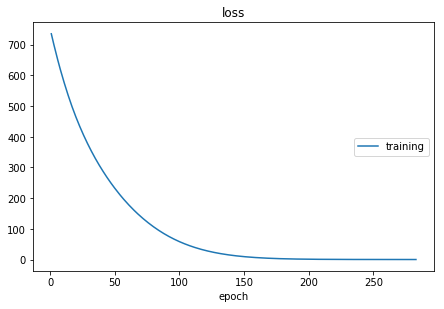

Epoch 284, loss 0.0149826770648


KeyboardInterrupt: 

In [49]:
from livelossplot import PlotLosses

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

liveloss = PlotLosses()

for t in range(500):
  # Forward pass: compute predicted y by passing x to the model.
  y_pred = model(x)

  # Compute and print loss.
  loss = loss_fn(y_pred, y)
  print "Epoch {}, loss {}".format(t+1, loss.item())
  
  # Before the backward pass, use the optimizer object to zero all of the
  # gradients for the Tensors it will update (which are the learnable weights
  # of the model)
  optimizer.zero_grad()

  # Backward pass: compute gradient of the loss with respect to model parameters
  loss.backward()

  # Calling the step function on an Optimizer makes an update to its parameters
  optimizer.step()
    
  liveloss.update({'loss': loss.item()})
  liveloss.draw()

## custom nn Modules

KeyboardInterrupt: 

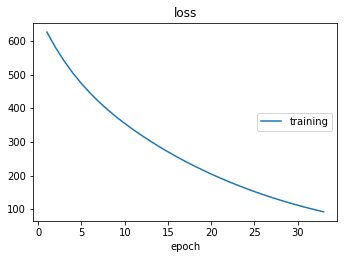

In [51]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return y_pred

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above.
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
loss_fn = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

liveloss = PlotLosses()

for t in range(500):
  # Forward pass: Compute predicted y by passing x to the model
  y_pred = model(x)

  # Compute and print loss
  loss = loss_fn(y_pred, y)
  print(t, loss.item())

  # Zero gradients, perform a backward pass, and update the weights.
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  liveloss.update({'loss': loss.item()})
  liveloss.draw()